In [1]:
from sklearn.metrics import roc_auc_score, roc_curve
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.metrics import recall_score
from sklearn.metrics import auc as auc_score
from sklearn.metrics import plot_roc_curve
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import json
import os
import glob
from natsort import natsorted
from sklearn.naive_bayes import GaussianNB
from sklearn.gaussian_process.kernels import RBF
from sklearn.neural_network import MLPClassifier
import PIL
from scipy import stats
import cv2 as cv

In [2]:
def z_score_scipy(scores_np):
    #increases it by about 0.2%
    scores = stats.zscore(scores_np)
    #scores = ndarray
    delete = []
    for i in range(len(scores)):
        if (abs(scores[i]) > 3.3):
            delete.append(i)
    scores_np = np.delete(scores_np, delete)
    return np.mean(scores_np)



def dbscan(scores_np):
    X = []
    for score in scores_np:
        X.append(score)

    X = np.asarray(X)

    y = []
    for i in X:
        y.append(0)

    from sklearn.cluster import DBSCAN
    from sklearn.preprocessing import StandardScaler
    
    new_X = []
    for old_scores in X:
        new_X.append([old_scores, 1])
        
    new_X=np.asarray(new_X)

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(new_X)

    dbscan = DBSCAN(eps=0.01, min_samples = 5)
    clusters = dbscan.fit_predict(X_scaled)
    
    filtered_data = [] 
    for i in range(len(dbscan.labels_)):
        if(dbscan.labels_[i] != -1):
            filtered_data.append(new_X[i][0])
            
    if(len(filtered_data) > 0 ):
        return np.mean(np.float_(filtered_data))
    else:
        return -1


In [3]:
cell_types_li = ['basophil',
 'eosinophil',
 'erythroblast',
 'garbage',
 'ig',
 'lymphocyte',
 'monocyte',
 'neutrophil',
 'platelet']

In [4]:
def filter_folder(fold, exclusion):
    new_fold = {}
    for patient, data in fold.items():
        new_fold[patient] = {
            'label': data['label'],
            'predictions': []
        }        
        for pred, filename in zip(data['predictions'], data['files']):
            if os.path.basename(filename) not in exclusion:
                new_fold[patient]['predictions'].append(pred)
    return new_fold

In [5]:
def softmax(x):
    return np.exp(x)/sum(np.exp(x))

def get_roc_auc(fold_data, thresh=1, method='median'):
    labels = []
    confs  = []
    for patient, data in fold_data.items():
        if len(data['predictions'])  > thresh:
            labels.append(data['label'])
            confs.append(aggregate_scores(data['predictions'], method))
        else:
            print(f"Discluding patient {patient} for only have {len(data['predictions'])} cells")
    fpr, tpr, thresholds = roc_curve(labels, confs)
    auc = roc_auc_score(labels, confs)
    return (fpr, tpr, thresholds), auc
    

In [6]:
def aggregate_scores(score_list, method='median'):
    """
    :param score_list: confidence scores for a patient, in list or as a np array. Should be for a single patient
    :param method: aggregation method to use (recommend mean or median)
    :return: aggregated score (single float)
    """
    scores_np = np.float_(score_list)
    if method == 'median':
        return np.median(scores_np)
    elif method == 'mean':
        return np.mean(scores_np)
    elif method == 'max':
        return np.max(scores_np)
    elif method == 'min':
        return np.min(scores_np)
    elif method == 'range':
        return np.max(scores_np) - np.min(scores_np)
    elif method == 'chance':
        return 1
    elif method == 'std':
        return np.std(scores_np)
    elif method == 'split':
        s1 = scores_np[scores_np < np.median(scores_np)]
        s2 = scores_np[scores_np > np.median(scores_np)]
        return np.mean([np.mean(s1), np.mean(s2)])
    elif method == 'hist':
        bins = np.arange(0, 1.1, 0.1)
        return np.histogram(scores_np, bins=bins, density=True)[0]
    elif method == 'exclude':
        scores = scores_np[(np.abs(scores_np - 0.5)) < 0.4]
        if len(scores) < 1:
            return aggregate_scores(scores_np)
        else:
            return np.mean(scores)
    elif method == 'dbscan':
        return dbscan(scores_np)
    elif method == 'z-score':
        return z_score_scipy(scores_np)


In [16]:
result_files = glob.glob('/home/colin/results_cov/covid_class_akzc50sq_fold_1_TTA_*.json')
folds = []
for result_file in result_files:
    with open(result_file) as fp:
        fold = json.load(fp)
        folds.append(fold)

In [196]:
keys = list(folds[0].keys())
pos_confs = [folds[0][key]['predictions'] for key in keys if folds[0][key]['label'] == 1]
pos_files = [folds[0][key]['files'] for key in keys if folds[0][key]['label'] == 1]
neg_confs = [folds[0][key]['predictions']  for key in keys if folds[0][key]['label'] == 0]
neg_files = [folds[0][key]['files'] for key in keys if folds[0][key]['label'] == 0]

In [190]:
all_the_best = []
for i in range(len(pos_confs)):
    best_args = np.argsort(pos_confs[i])[::-1][0:4]
    best_files = np.array(pos_files[i])[best_args]
    best_filepaths = [glob.glob(f'/hddraid5/data/colin/covid-data/aug_24/COVID Research Images/**/{f}', recursive=True)[0] for f in best_files]
    best_images = [cv.cvtColor(cv.imread(bf), cv.COLOR_BGR2RGB) for bf in best_filepaths]
    all_the_best += best_images


In [99]:
with open('/home/colin/results_cov/cell_level/covid_class_1abip6we_fold_0.json') as fp:
    tt = json.load(fp)
    asd = {patient: data['predictions'] for patient, data in tt.items() if 'predictions' in data}

In [107]:
result_files

['/home/colin/results_cov/cell_level/covid_class_3fdw8njf_fold_0.json',
 '/home/colin/results_cov/cell_level/covid_class_1abip6we_fold_0.json',
 '/home/colin/results_cov/cell_level/covid_class_3au2k57i_fold_1.json',
 '/home/colin/results_cov/cell_level/covid_class_1l33ib88_fold_1.json',
 '/home/colin/results_cov/cell_level/covid_class_1d3hpvs0_fold_2.json',
 '/home/colin/results_cov/cell_level/covid_class_1ngmy2jz_fold_2.json',
 '/home/colin/results_cov/cell_level/covid_class_z6u8j84u_fold_3.json',
 '/home/colin/results_cov/cell_level/covid_class_jaqln5pf_fold_3.json',
 '/home/colin/results_cov/cell_level/covid_class_171f08s0_fold_4.json',
 '/home/colin/results_cov/cell_level/covid_class_jup6btte_fold_4.json',
 '/home/colin/results_cov/cell_level/covid_class_1dbrkt2i_fold_5.json',
 '/home/colin/results_cov/cell_level/covid_class_2qyssv3y_fold_5.json']

In [149]:
result_files = sorted(glob.glob('/home/colin/results_cov/cell_level/*.json'), key=lambda x: x[-6])
all_patients = {}
folds = []
val_folds = []
fold_numbers = []
for result_file in sorted(result_files, key=lambda x: int(x[-6])):
    with open(result_file) as fp:
        fn = int(result_file[-6])
        all_data = json.load(fp)        
        test_fold = {patient: data for patient, data in all_data.items() if 'predictions' in data}
        val_fold = {patient: data for patient, data in all_data.items() if 'val_predictions' in data}
        if fn in fold_numbers:
            new_fold = {patient + '_': data for patient, data in test_fold.items()}              
            new_fold_v = {patient + '_': data for patient, data in val_fold.items()}              
            folds[-1].update(new_fold)
            val_folds[-1].update(new_fold_v)
        else:
            fold_numbers.append(fn)                          
            folds.append(test_fold)
            val_folds.append(val_fold)
        all_patients.update(fold)

## NORMAL DATA (GROUP A)

In [9]:
result_files = sorted(glob.glob('/home/colin/results_cov/cell_level/*.json'), key=lambda x: x[-6])
result_files = [r for r in result_files if 'control' not in r]
all_patients = {}
folds = []
val_folds = []
fold_numbers = []
for result_file in sorted(result_files, key=lambda x: int(x[-6])):
    with open(result_file) as fp:
        fn = int(result_file[-6])
        all_data = json.load(fp)        
        test_fold = {patient: data for patient, data in all_data.items() if 'predictions' in data}
        val_fold = {patient: data for patient, data in all_data.items() if 'val_predictions' in data}
        if fn in fold_numbers:
            fn = fn + 6
        fold_numbers.append(fn)                          
        folds.append(test_fold)
        val_folds.append(val_fold)

## CONTROL DATA (GROUP B + GROUP A POS)

In [39]:
control_files = sorted(glob.glob('/home/colin/results_cov/cell_level/*control.json'), key=lambda x: x[-20 - len('_control'):-12-len('_control')])
result_files = sorted(glob.glob('/home/colin/results_cov/cell_level/*.json'), key=lambda x: x[-20:-12])
result_files = [r for r in result_files if 'control' not in r]

control_folds = []
control_fold_numbers = []
for result_file, control_file in zip(result_files, control_files):
    fn = int(result_file[-6])
    with open(result_file) as fp:
        all_data = json.load(fp)
    with open(control_file) as fp:
        control_data = json.load(fp)
    control_fold = {patient: {'predictions':data['controlpredictions'], 'label': data['controllabel']} for patient, data in control_data.items()}
    pos_fold = {patient: data for patient, data in all_data.items() if ('predictions' in data and data['label']==1)}
    control_fold.update(pos_fold)
    control_folds.append(control_fold)
    if fn in control_fold_numbers:
        fn += 6
    control_fold_numbers.append(fn)
    
# all_patients = {}
# folds = []
# val_folds = []
# fold_numbers = []
# for result_file in sorted(result_files, key=lambda x: int(x[-6])):
#     with open(result_file) as fp:
#         fn = int(result_file[-6])
#         all_data = json.load(fp)        
#         test_fold = {patient: data for patient, data in all_data.items() if 'predictions' in data}
#         val_fold = {patient: data for patient, data in all_data.items() if 'val_predictions' in data}
#         if fn in fold_numbers:
#             fn = fn + 6
#         fold_numbers.append(fn)                          
#         folds.append(test_fold)
#         val_folds.append(val_fold)

In [40]:
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
def fold_roc_auc(folds, plotting=True, exclude_cells=None, method='median', fold_names=None):
    mean_fpr = np.linspace(0, 1, 100)
    if exclude_cells is not None:
        folds = [filter_folder(fold, set(exclude_cells)) for fold in folds]
    if plotting:
        fig, ax = plt.subplots()
    for i, fold in enumerate(folds):
        (fpr, tpr, thresholds), auc = get_roc_auc(fold, method=method)
        if plotting and len(folds) > 1:
            if fold_names is not None:
                ax.plot(fpr, tpr, label=f'{fold_names[i]} - AUC: {auc:.3f}', alpha=0.75)
            else:
                ax.plot(fpr, tpr, label=f'ROC fold {i+1} - AUC: {auc:.3f}', alpha=0.5)
        interp_tpr = np.interp(mean_fpr, fpr, tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(auc)
    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc_score(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    if plotting:

        ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
        ax.plot(mean_fpr, mean_tpr, color='b',
                label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
                lw=2, alpha=.8)
        ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                        label=r'$\pm$ 1 std. dev.')
        ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
               title=f"Receiver Operating Characteristic \nMedian Aggregration Cell Level Only\n AUC={mean_auc:.3f} $\pm${std_auc:.3f}")
        ax.legend(loc="lower right")
        ax.set_xlabel("False Positive Rate")
        ax.set_ylabel("True Positive Rate")
        plt.show()
    return mean_auc

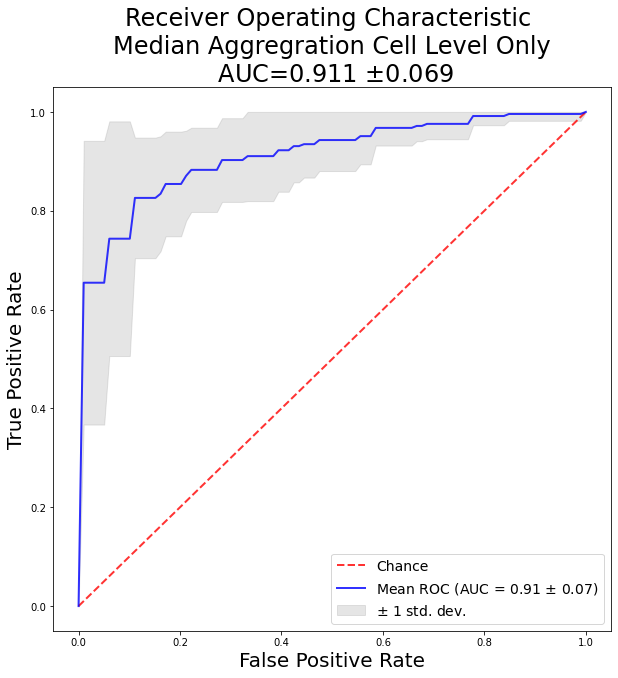

In [12]:
fig, ax = plt.subplots(figsize=(10,10))
for i, fold in zip(fold_numbers, folds):
    (fpr, tpr, thresholds), auc = get_roc_auc(fold)
#     ax.plot(fpr, tpr, label=f'ROC fold {i%6 + 1} Seed {i//6} - AUC: {auc:.3f}', alpha=0.5)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc_score(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_title(f"Receiver Operating Characteristic \nMedian Aggregration Cell Level Only\n AUC={mean_auc:.3f} $\pm${std_auc:.3f}", fontsize=24)
ax.legend(loc="lower right", fontsize=14)
ax.set_xlabel("False Positive Rate", fontsize=20)
ax.set_ylabel("True Positive Rate", fontsize=20)
plt.show()

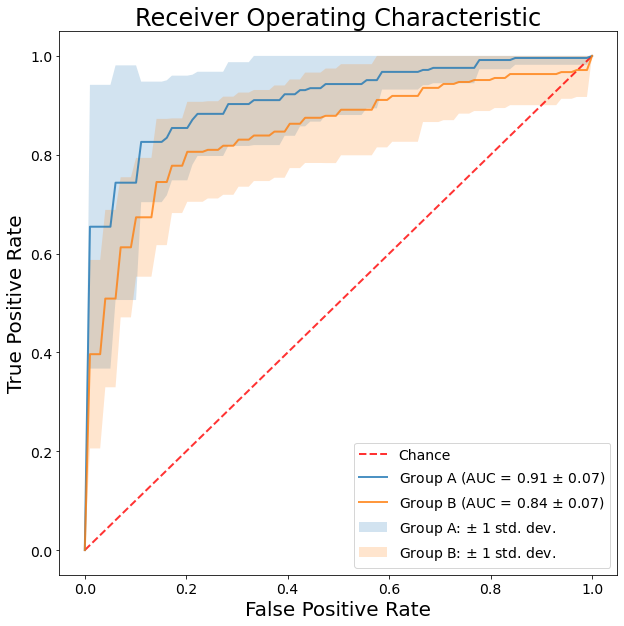

In [53]:
fig, ax = plt.subplots(figsize=(10,10))

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, fold in zip(fold_numbers, folds):
    (fpr, tpr, thresholds), auc = get_roc_auc(fold)
#     ax.plot(fpr, tpr, label=f'ROC fold {i%6 + 1} Seed {i//6} - AUC: {auc:.3f}', alpha=0.5)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r', label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc_score(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr,
        label=r'Group A (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.2,
                label=r'Group A: $\pm$ 1 std. dev.')
tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
for i, fold in zip(control_fold_numbers, control_folds):
    (fpr, tpr, thresholds), auc = get_roc_auc(fold)
#     ax.plot(fpr, tpr, label=f'ROC fold {i%6 + 1} Seed {i//6} - AUC: {auc:.3f}', alpha=0.5)
    interp_tpr = np.interp(mean_fpr, fpr, tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(auc)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc_score(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr,
        label=r'Group B (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, alpha=.2,
                label=r'Group B: $\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_title(f"Receiver Operating Characteristic", fontsize=24)
ax.legend(loc="lower right", fontsize=14)
ax.set_xlabel("False Positive Rate", fontsize=20)
ax.set_ylabel("True Positive Rate", fontsize=20)
ax.tick_params(axis="x", labelsize=14)
ax.tick_params(axis="y", labelsize=14)
plt.show()

In [83]:
# effective acc calculation
accs = []
for fold in folds:
    all_preds = np.array([np.median(data['predictions']) for _, data in fold.items()])
    all_labels = np.array([data['label'] for _, data in fold.items()])
    acc = 0
    best_thresh = 0
    for thresh in np.linspace(0, 1, 10000):
        new_acc = np.sum((all_preds > thresh).astype(np.int) == all_labels) / len(all_labels)
        if new_acc > acc:
            acc = new_acc
            best_thresh = thresh
    accs.append(acc)
    


In [85]:
accs = []
for fold in control_folds:
    all_preds = np.array([np.median(data['predictions']) for _, data in fold.items()])
    all_labels = np.array([data['label'] for _, data in fold.items()])
    acc = 0
    best_thresh = 0
    for thresh in np.linspace(0, 1, 10000):
        new_acc = np.sum((all_preds > thresh).astype(np.int) == all_labels) / len(all_labels)
        if new_acc > acc:
            acc = new_acc
            best_thresh = thresh
    accs.append(acc)

In [86]:
np.mean(accs)

0.8437581699346407

In [80]:
from sklearn.metrics import accuracy_score

In [81]:
accuracy_score(all_labels, (all_preds > thresh))

0.48717948717948717

In [79]:
(all_preds < thresh).astype(np.int)

array([False, False, False,  True,  True,  True,  True, False, False,
        True, False, False, False,  True, False, False,  True,  True,
       False,  True,  True,  True, False, False,  True, False,  True,
       False, False, False,  True,  True, False, False,  True,  True,
        True, False, False])

In [78]:
all_labels

array([0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0])

In [72]:
for thresh in np.linspace(0, 1, 4):
    new_acc = np.sum((all_preds < thresh).astype(np.int) == all_labels) / len(all_labels)
    if new_acc > acc:
        acc = new_acc
        best_thresh = thresh
    print(thresh)

0.0
0.3333333333333333
0.6666666666666666
1.0


In [74]:
all_preds

array([4.82529789e-01, 9.35618579e-03, 4.14684806e-02, 9.93328720e-01,
       8.19543839e-01, 9.99999404e-01, 9.99995232e-01, 4.05683834e-02,
       1.00000000e+00, 9.03999209e-01, 5.08178368e-06, 5.11496186e-01,
       1.18266289e-04, 9.99998331e-01, 2.35858327e-03, 1.31834997e-06,
       5.94281661e-03, 3.10147676e-04, 1.31670234e-07, 9.99999166e-01,
       9.91510063e-01, 9.99999642e-01, 1.97917824e-08, 3.47328861e-03,
       9.73392457e-01, 1.94698732e-04, 6.22823119e-01, 1.00000000e+00,
       6.07643634e-01, 7.50946850e-01, 3.49775791e-01, 4.23749852e-05,
       4.22214889e-02, 5.41604683e-03, 9.53070283e-01, 9.98223245e-01,
       7.88395904e-04, 1.91897980e-05, 1.43451529e-06])

In [ ]:
best_thresh

0.1794871794871795

In [66]:
acc = 0
for thresh in np.linspace(0, 1, 1000):
    new_acc = np.sum((all_preds < thresh).astype(np.int) == all_labels) / len(all_labels)
    if new_acc > acc:
        acc = new_acc

In [67]:
acc

0.46153846153846156

In [45]:
wbc_types_by_patient = {}
wbc_data_path = '/home/colin/wbc_class_uf6amfjz_v5.json'
with open(wbc_data_path) as fp:
    wbc_data = json.load(fp)
wbc_file_by_type = {cell_type:[] for cell_type in cell_types_li}
for filename, cell_type in wbc_data.items():
    wbc_file_by_type[cell_types_li[cell_type]].append(os.path.basename(filename))

In [46]:
for filename, cell_type in wbc_data.items():
    order = os.path.basename(filename).split('_')[0]
    try:
        int(order)
    except:
        order = os.path.basename(os.path.dirname(filename))
        int(order)
    if order not in wbc_types_by_patient:
        wbc_types_by_patient[order] = [0.0 for _ in range(9)]
    wbc_types_by_patient[order][cell_type] += 1
    

### plt.plot(np.array(all_dists)[:,2])

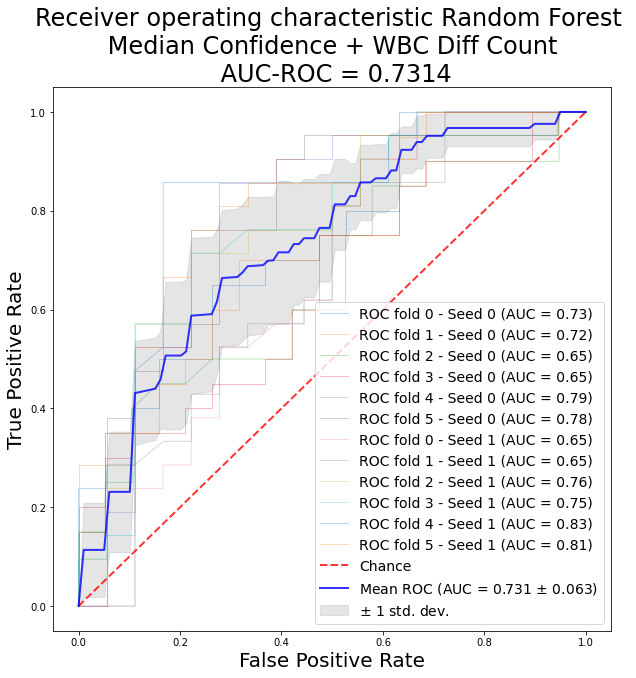

In [223]:
from sklearn.neural_network import MLPClassifier
tprs_rf = []
aucs_rf = []
mean_fpr_rf = np.linspace(0, 1, 100)
fig, ax = plt.subplots(figsize=(10,10))
preds = []
ag_method = 'median'
all_dists = []
for i, (fold, val_fold) in enumerate(zip(folds, val_folds)):
# for i, fold in enumerate(folds):
    x_data_train = []
    y_data_train = []
    x_data_test = []
    y_data_test = []
    all_patients
    for patient in fold.keys():
        if '_' in patient:
            wb_p = patient[:-1]
        else:
            wb_p = patient
        wbc_types = np.array(wbc_types_by_patient[wb_p])
        wbc_dist = (wbc_types/np.sum(wbc_types)).tolist()
        all_dists.append(wbc_dist)
        features = wbc_dist
#         features = []
        conf = aggregate_scores(fold[patient]['predictions'], method=ag_method)
#         features += [conf]
        y_data_test.append(fold[patient]['label'])
        x_data_test.append(features)
    for patient in val_fold.keys():
        if '_' in patient:
            wb_p = patient[:-1]
        else:
            wb_p = patient
        if patient in fold:
            continue
        wbc_types = np.array(wbc_types_by_patient[wb_p])
        wbc_dist = (wbc_types/np.sum(wbc_types)).tolist()
        features = wbc_dist
#         features = []
        conf = aggregate_scores(val_fold[patient]['val_predictions'], method=ag_method)
#         features += [conf]
        y_data_train.append(val_fold[patient]['val_label'])
        x_data_train.append(features)
    classifier = RandomForestClassifier(n_estimators=1000, criterion='entropy')
    classifier.fit(x_data_train, y_data_train, )
    viz = plot_roc_curve(classifier, x_data_test, y_data_test,
                         name='ROC fold {} - Seed {}'.format(i%6, i//6),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr_rf = np.interp(mean_fpr_rf, viz.fpr, viz.tpr)
    interp_tpr_rf[0] = 0.0
    tprs_rf.append(interp_tpr_rf)
    aucs_rf.append(viz.roc_auc)
    preds.append(classifier.predict(x_data_test) == y_data_test)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr_rf = np.mean(tprs_rf, axis=0)
mean_tpr_rf[-1] = 1.0
mean_auc_rf = auc_score(mean_fpr_rf, mean_tpr_rf)
std_auc_rf = np.std(aucs_rf)
ax.plot(mean_fpr_rf, mean_tpr_rf, color='b',
        label=r'Mean ROC (AUC = %0.3f $\pm$ %0.3f)' % (mean_auc_rf, std_auc_rf),
        lw=2, alpha=.8)
std_tpr_rf = np.std(tprs_rf, axis=0)
tprs_upper_rf = np.minimum(mean_tpr_rf + std_tpr_rf, 1)
tprs_lower_rf = np.maximum(mean_tpr_rf - std_tpr_rf, 0)
ax.fill_between(mean_fpr_rf, tprs_lower_rf, tprs_upper_rf, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_title(f"Receiver operating characteristic Random Forest \n Median Confidence + WBC Diff Count \n AUC-ROC = {mean_auc_rf:.4f}", fontsize=24)
ax.legend(loc="lower right", fontsize=14)
ax.set_xlabel('False Positive Rate', fontsize=20)
ax.set_ylabel('True Positive Rate', fontsize=20)
plt.show()

In [147]:
roc_auc_score(np.array(y_data_train), classifier.predict_proba(x_data_train)[:,1])

1.0

In [82]:
auc

0.9232804232804233

In [23]:
cpreds = np.concatenate(preds)
np.sum(cpreds)/len(cpreds)

0.8148148148148148

In [24]:
for i, (train, test) in enumerate(cv.split(X, y)):
    
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)
std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')
ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic Random Forest \n Mean Confidence + WBC Diff Count")
ax.legend(loc="lower right")
plt.show()

IndentationError: expected an indented block (<ipython-input-24-b2e5672ef1be>, line 3)

In [25]:
# lets get the best acc
thresholds = np.linspace(0,1,100)
all_confs = np.array([aggregate_scores(data['predictions']) for data in all_patients.values()])
labels = np.array([data['label'] for data in all_patients.values()])

In [26]:
acc = 0
t = 0
for thresh in thresholds:
    tt = all_confs > thresh
    new_acc = np.count_nonzero(tt == labels)/len(tt)
    if new_acc > acc:
        acc = new_acc
        

In [27]:
with open('/home/colin/testing/wbc_class_1dr34rc5_v2_cont.json') as fp:
    cont_data = json.load(fp)
soft_data = {key:softmax(value) for key, value in cont_data.items()}
soft_base = {os.path.basename(key):softmax(value) for key, value in cont_data.items()}

In [28]:
low_conf_files = []
for key, value in soft_base.items():
    if np.max(value)

SyntaxError: invalid syntax (<ipython-input-28-2538d7b3cd23>, line 3)

In [29]:
# lets hack our way to an accuracy score
users = ['colin', 'shiqi', 'kanghyun', 'xing', 'sam', 'vinayak']
folders = ['review_rev3', 'review', 'review', 'review', 'review', 'review']

In [30]:
with open('/home/colin/testing/wbc_class_1dr34rc5.json') as fp:
    wbc_class_data = json.load(fp)
    wbc_class_data = {os.path.basename(f): k for f,k in wbc_class_data.items()}

In [31]:
done_images = []
good_by_type = {cell_type:[] for cell_type in cell_types_li}
for user, folder in zip(users, folders):
    done_folders = glob.glob(os.path.join(f'/home/{user}', folder, '*_done'))
    for done_folder in done_folders:
        images = [os.path.basename(f) for f in glob.glob(os.path.join(done_folder, '*.jpg'))]
        for cell_type in cell_types_li:
            if cell_type in done_folder:
                good_by_type[cell_type] += images
        done_images += images
done_images = set(done_images)

In [32]:
misclassified = {k:s for k,s in wbc_class_data.items() if k not in done_images}

In [33]:
overall = [0 for _ in range(9)]
for _, cls in wbc_class_data.items():
    overall[cls] += 1
misc = [0 for _ in range(9)]
for file, cls in misclassified.items():
    misc[cls] += 1

In [34]:
confs = [[] for _ in range(9)]
misc_confs = [[] for _ in range(9)]

In [35]:
for file, conf in soft_base.items():
    ind = np.argmax(conf)
    confs[ind].append(conf[ind])
    if file in misclassified:
        misc_confs[ind].append(conf[ind])

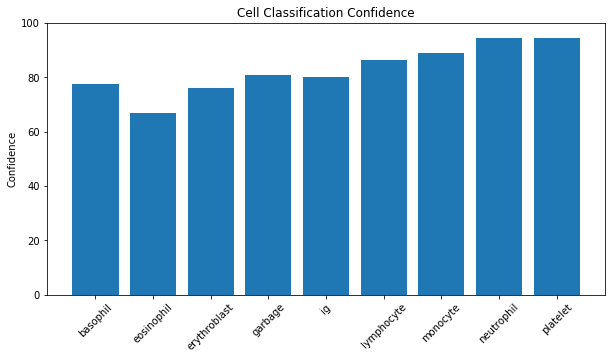

In [36]:
plt.figure(figsize=(10, 5))
plt.title("Cell Classification Confidence")
x_data = np.arange(0, 9)
y_data = np.array(([np.mean(c) for c in confs]))*100
plt.bar(x_data, y_data)
plt.xticks(ticks=x_data, labels=cell_types_li, rotation=45)
plt.ylabel("Confidence")
plt.ylim(0, 100)
plt.show()

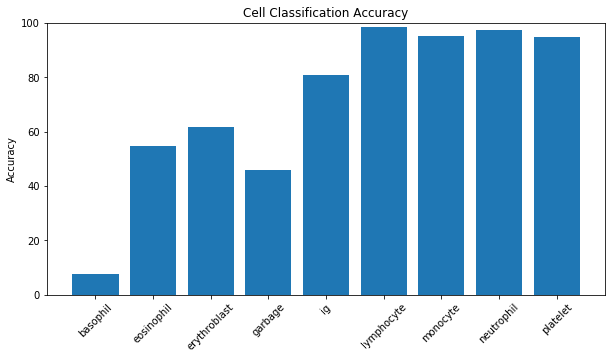

In [37]:
plt.figure(figsize=(10, 5))
plt.title("Cell Classification Accuracy")
x_data = np.arange(0, 9)
y_data = (1 - np.array(misc)/np.array(overall))*100
plt.bar(x_data, y_data)
plt.xticks(ticks=x_data, labels=cell_types_li, rotation=45)
plt.ylabel("Accuracy")
plt.ylim(0, 100)
plt.show()

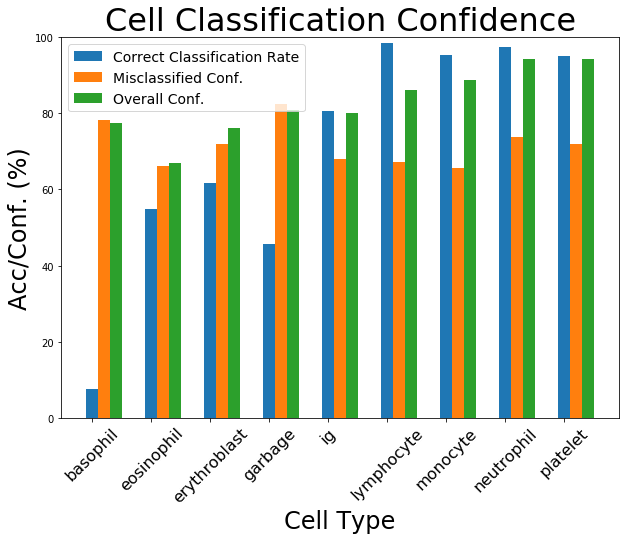

In [38]:
plt.figure(figsize=(10, 7))
plt.title("Cell Classification Confidence", fontsize=32)
width = 0.2
x_data = np.arange(0, 9)
y_data = (1 - np.array(misc)/np.array(overall))*100
x_data_2 = np.arange(0, 9) + width
y_data_2 = np.array(([np.mean(c) for c in misc_confs]))*100
x_data_3 = np.arange(0, 9) + 2*width
y_data_3 = np.array(([np.mean(c) for c in confs]))*100
plt.bar(x_data, y_data, width=width, label='Correct Classification Rate')
plt.bar(x_data_2, y_data_2, width=width, label="Misclassified Conf.")
plt.bar(x_data_3, y_data_3, width=width, label="Overall Conf.")
plt.xticks(ticks=x_data, labels=cell_types_li, rotation=45, fontsize=16)
plt.ylabel("Acc/Conf. (%)", fontsize=24)
plt.xlabel("Cell Type", fontsize=24)
plt.ylim(0, 100)
plt.legend(fontsize=14)
plt.show()

In [39]:
miscs = [[] for _ in range(9)]
confs = [[] for _ in range(9)]
for filename, conf in soft_data.items():
    name = os.path.basename(filename)
    if name in misclassified:
        ind = np.argmax(conf)
        miscs[ind].append(filename)
        confs[ind].append(conf[ind])

FileNotFoundError: [Errno 2] No such file or directory: '/hddraid5/data/colin/covid-data/COVID Research Images/April 27, 2020/April 27 2020/10049502684/Not WBC/10049502684_064.jpg'

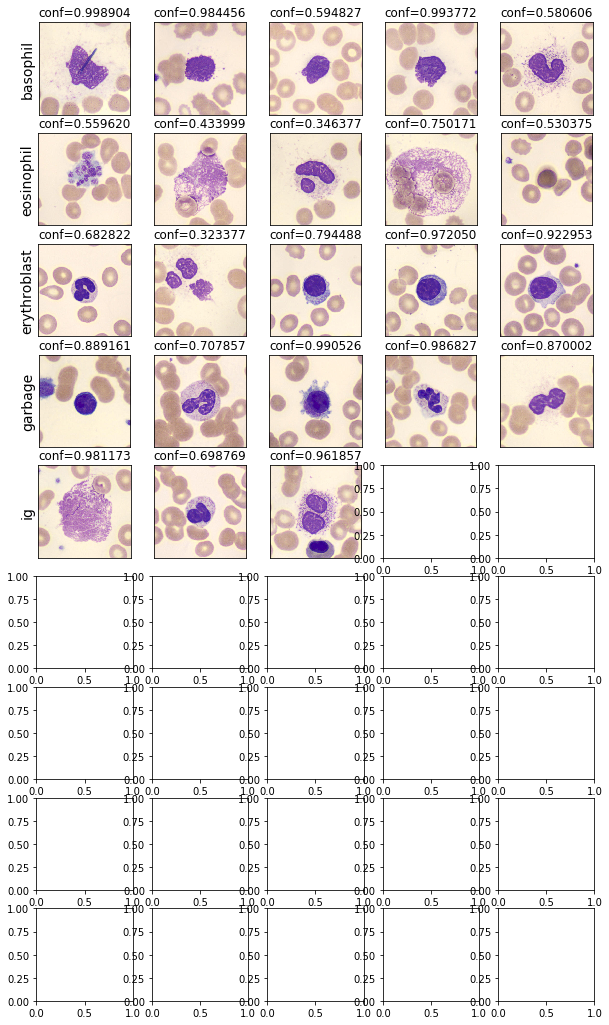

In [40]:
fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(5*2, 9*2))
for i, cell_type in enumerate(cell_types_li):
    sample_inds = np.random.choice(np.arange(0, len(miscs[i])), size=5, replace=False)
    axs[i][0].set_ylabel(cell_type, fontsize=14)
    for j, sample_ind in enumerate(sample_inds):
        image = PIL.Image.open(miscs[i][sample_ind])
        axs[i][j].imshow(image)
        axs[i][j].set_title(f"conf={confs[i][sample_ind]:2f}")
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        

In [ ]:
miscs = [[] for _ in range(9)]
confs = [[] for _ in range(9)]
for filename, conf in soft_data.items():
    name = os.path.basename(filename)
    if name not in misclassified:
        ind = np.argmax(conf)
        miscs[ind].append(filename)
        confs[ind].append(conf[ind])

In [ ]:
fig, axs = plt.subplots(nrows=9, ncols=5, figsize=(5*2, 9*2))
for i, cell_type in enumerate(cell_types_li):
    sample_inds = np.random.choice(np.arange(0, len(miscs[i])), size=5, replace=False)
    axs[i][0].set_ylabel(cell_type, fontsize=14)
    for j, sample_ind in enumerate(sample_inds):
        image = PIL.Image.open(miscs[i][sample_ind])
        axs[i][j].imshow(image)
        axs[i][j].set_title(f"conf={confs[i][sample_ind]:2f}")
        axs[i][j].set_xticks([])
        axs[i][j].set_yticks([])
        